In [1]:
%matplotlib inline
import calendar
import configparser
import datetime
import os

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Get API key for HydAPI
config = configparser.RawConfigParser()
config.read("../.nve-hydapi-key")
api_key = config.get("Auth", "key")

# Elveovervåkingsprogrammet - average monthly temperatures

This notebook calculates average monthly temperatures for the 20 main rivers in the 2021-22 monitoring programme. Data come from a variety of sources, so the workflow is a bit messy. See e-mail from Liv Bente received 31.08.2021 at 12.26 for more details. In addition, the spreadsheet here shows which data sources are usually used for which stations:

    K:\Prosjekter\Ferskvann\16384 Elveovervåkingsprogrammet\2019\4. Data\6. Vanntemperatur\Grunnprogrammet\2018_TempData_Overview_oppdat for 2019_28aug20.xlsx

**Note:** In this notebook I have attempted to switch to HydAPI instead of Hydra-II for the temperature data.

## 1. Get manual data from RESA2

The code below gets all the temperature data from RESA2 and calculates monthly averages.

In [2]:
# Connect to db
eng = nivapy.da.connect()

Username:  ········
Password:  ········


Connection successful.


In [3]:
# Year of interest
year = 2021

In [4]:
# Find project
prj_df = nivapy.da.select_resa_projects(eng)
prj_df = prj_df[prj_df["project_name"].str.contains('lveovervåking', na=False)]
prj_df

599 projects in the RESA database.


,project_id,project_number,project_name,contact_person,project_description
571,4230,O 16384,Elveovervåkingsprogrammet,None,Videreføring av RID. Tilførsler fra elver til ...
590,4551,O 200310 03,Elveovervåking hovedelver 2021-25,Øyvind Kaste,Videreføring av Elveovervåkingsprogrammet


In [5]:
# Get stations
stn_df = nivapy.da.select_resa_project_stations([4551], eng)
stn_df

,station_id,station_code,station_name,latitude,longitude,altitude
0,29612,BUSEDRA,Drammenselva,NaN,NaN,None
1,29613,TELESKI,Skienselva,NaN,NaN,None
2,29614,VAGEOTR,Otra,NaN,NaN,None
3,29615,VESENUM,Numedalslågen,NaN,NaN,None
4,29617,ØSTEGLO,Glomma ved Sarpsfoss,59.279802,11.134111,None
5,29778,STREORK,Orkla,NaN,NaN,None
6,29779,FINEALT,Altaelva,69.900992,23.286977,None
7,29782,NOREVEF,Vefsna,NaN,NaN,None
8,29783,ROGEORR,Orreelva,NaN,NaN,None
9,29819,FINEPAS,Pasvikelva,NaN,NaN,None


In [6]:
# Not interested in TROEMÅL (it has now been replaced by TROEMÅL2)
stn_df = stn_df.query("station_id != 29848")

In [7]:
# Find ID for temp var
par_grid = nivapy.da.select_resa_station_parameters(
    stn_df, f"{year}-01-01", f"{year}-12-31", eng
)
par_grid.query('parameter_name == "Temp"')

40 parameters available for the selected stations and dates.


,parameter_id,parameter_name,unit
35,125,Temp,oC


In [8]:
# Get temp data
wc_df, dup_df = nivapy.da.select_resa_water_chemistry(
    stn_df,
    [125],
    f"{year}-01-01",
    f"{year}-12-31",
    eng,
)

wc_df.head()

,station_id,station_code,station_name,sample_date,depth1,depth2,Temp_oC
,,,,,,,
0,29612,BUSEDRA,Drammenselva,2021-01-21 10:30:00,0,0,1.3
1,29612,BUSEDRA,Drammenselva,2021-02-02 15:00:00,0,0,0.2
2,29612,BUSEDRA,Drammenselva,2021-03-02 08:30:00,0,0,0.8
3,29612,BUSEDRA,Drammenselva,2021-04-06 11:30:00,0,0,2.6
4,29612,BUSEDRA,Drammenselva,2021-05-03 09:00:00,0,0,5.8


In [9]:
# Print number of measurements in year for each site
print(wc_df[["station_id", "Temp_oC"]].groupby("station_id").count())

# Aggregate to monthly
wc_df["month"] = wc_df["sample_date"].dt.month
agg = wc_df[["station_id", "month", "Temp_oC"]].groupby(["station_id", "month"])
mon_df = agg.mean().reset_index()

            Temp_oC
station_id         
29612            16
29613             2
29615             1
29617            16
29778             1
29782             1
29819            12
29820            12
29822            12
29832            12
29837             1
29842            11
29844            12
36225            11
38005            11


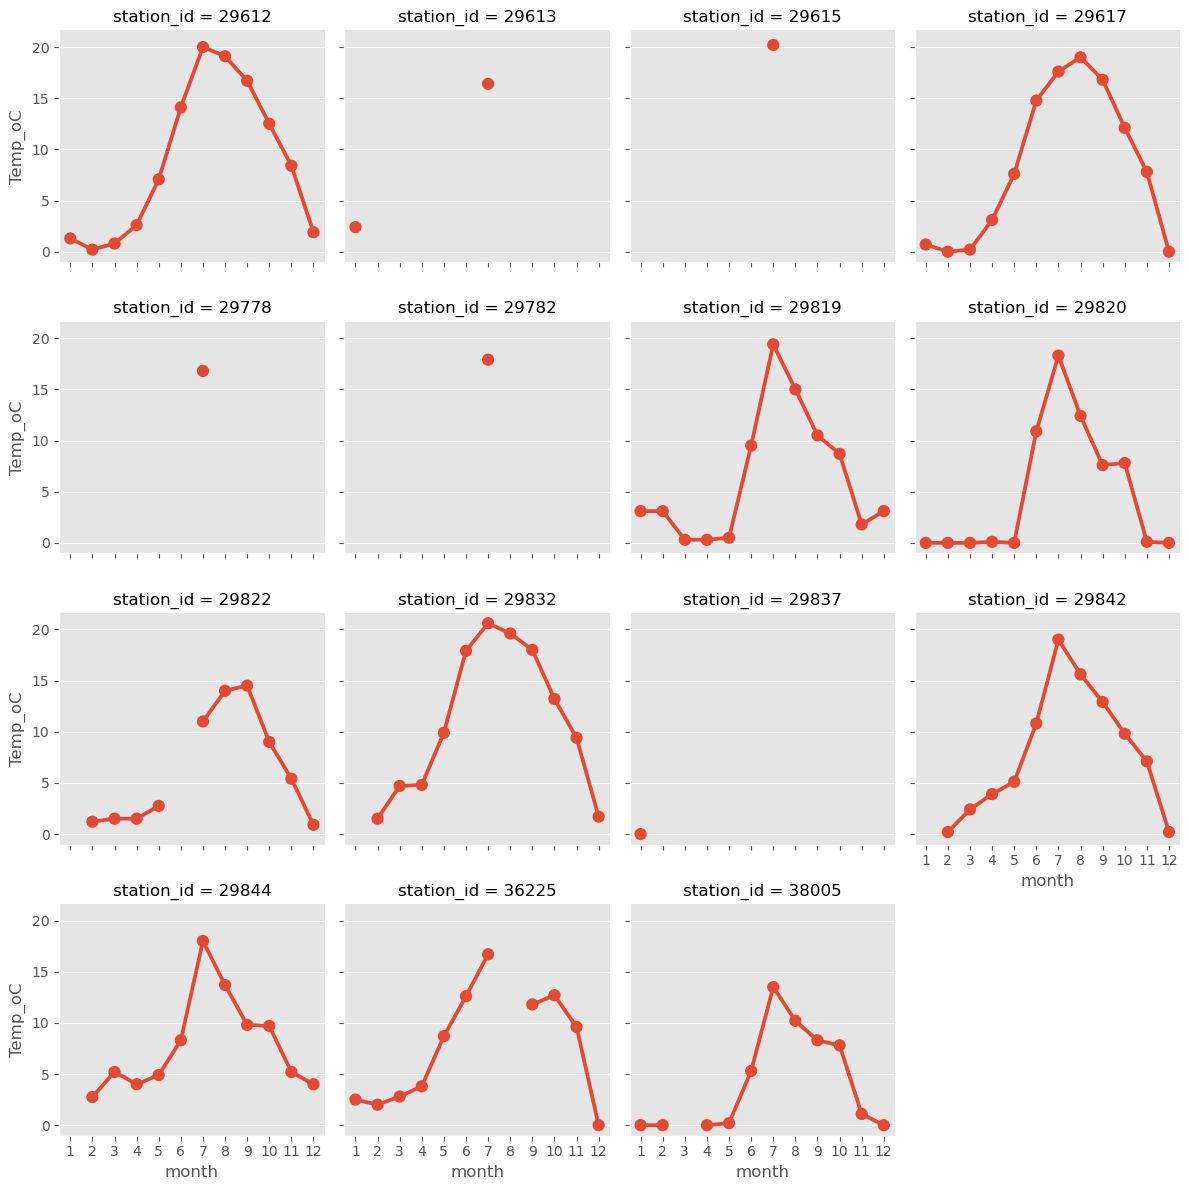

In [10]:
# Plot monthly means
sn.catplot(
    x="month",
    y="Temp_oC",
    data=mon_df,
    col="station_id",
    col_wrap=4,
    kind="point",
    height=3,
)

# Save
out_path = f"../../../../Data/temperature_data/temp_{year}-{year - 1999}/other/temps_manual_{year}.png"
plt.savefig(out_path, dpi=300)

In [11]:
# Pivot to "wide" format
man_df = mon_df.pivot(index="station_id", columns="month", values="Temp_oC")

man_df

month,1,2,3,4,5,6,7,8,9,10,11,12
station_id,,,,,,,,,,,,
29612,1.3,0.20,0.8,2.6,7.066667,14.100000,20.0,19.1,16.7,12.5,8.4,1.9
29613,2.4,NaN,NaN,NaN,NaN,NaN,16.4,NaN,NaN,NaN,NaN,NaN
29615,NaN,NaN,NaN,NaN,NaN,NaN,20.2,NaN,NaN,NaN,NaN,NaN
29617,0.7,0.00,0.2,3.1,7.600000,14.766667,17.6,19.0,16.8,12.1,7.8,0.0
29778,NaN,NaN,NaN,NaN,NaN,NaN,16.8,NaN,NaN,NaN,NaN,NaN
29782,NaN,NaN,NaN,NaN,NaN,NaN,17.9,NaN,NaN,NaN,NaN,NaN
29819,3.1,3.10,0.3,0.3,0.500000,9.500000,19.4,15.0,10.5,8.7,1.8,3.1
29820,0.0,0.00,0.0,0.1,0.000000,10.900000,18.3,12.4,7.6,7.8,0.1,0.0
29822,NaN,1.20,1.5,1.5,2.750000,NaN,11.0,14.0,14.5,9.0,5.4,0.9


Based on Liv Bente's spreadsheet here

    K:\Prosjekter\Ferskvann\16384 Elveovervåkingsprogrammet\2019\4. Data\6. Vanntemperatur\Grunnprogrammet\2018_TempData_Overview_oppdat for 2019_28aug20.xlsx
    
we will use the data from RESA for 9 stations. Filter to just these.

In [12]:
# Filter to desired stations for RESA
resa_list = [29617, 36225, 29612, 29832, 29842, 29822, 29844, 29820, 29819]
man_df = man_df.query("station_id in @resa_list")

## 2. TinyTag data

TinyTags are deployed in 7 rivers and the sensors are swapped in the middle of the year, so we need to splice together two data files for each location. The TinyTags are often recording even when they're out of the water, so it's important to know the date when each logger was taken in/set out. See Liv Bente's spreadsheet here:

    K:\Prosjekter\Ferskvann\16384 Elveovervåkingsprogrammet\2020\4. Data\6. Vanntemperatur\1. TinyTag temperatursensor\1. Oversikt inn ut setting templogger RID hoved 2014-15-16-17-18-19_lbs.xlsx
    
**Note:** The date format in the text files sometimes changes (e.g from `%d.%m.%Y %H.%M.%S,%f` to `%d.%m.%Y %H:%M:%S,%f`), so it might be necessary to modify the code below. The raw files may also need converting to UTF-8.

In [13]:
# Dates from Liv Bente's spreadsheet for 2018
swap_dates = {
    29615: ["Numedalslagen", "2021-07-05 08:15"],
    29613: ["Skienselva", "2021-06-06 18:00"],
    29614: ["Otra", "2021-06-07 09:30"],
    29783: ["Orreelva", "2021-06-07 07:00"],
    29821: ["Vosso", "2021-06-07 11:56"],
    29782: ["Vefsna", "2021-08-09 10:00"],
    29779: ["Altaelva", "2021-07-07 12:35"],
}

# Base folder (with tidied file names)
data_fold = r"../../../../Data/temperature_data"

# Define date and decimal format for the current and previous year
curr_dt_fmt = "%d.%m.%Y %H:%M:%S.%f"
prev_dt_fmt = "%d.%m.%Y %H:%M:%S.%f"
curr_dec_sep = "."
prev_dec_sep = "."

Numedalslagen
Skienselva
Otra
Orreelva
Vosso
Vefsna
Altaelva


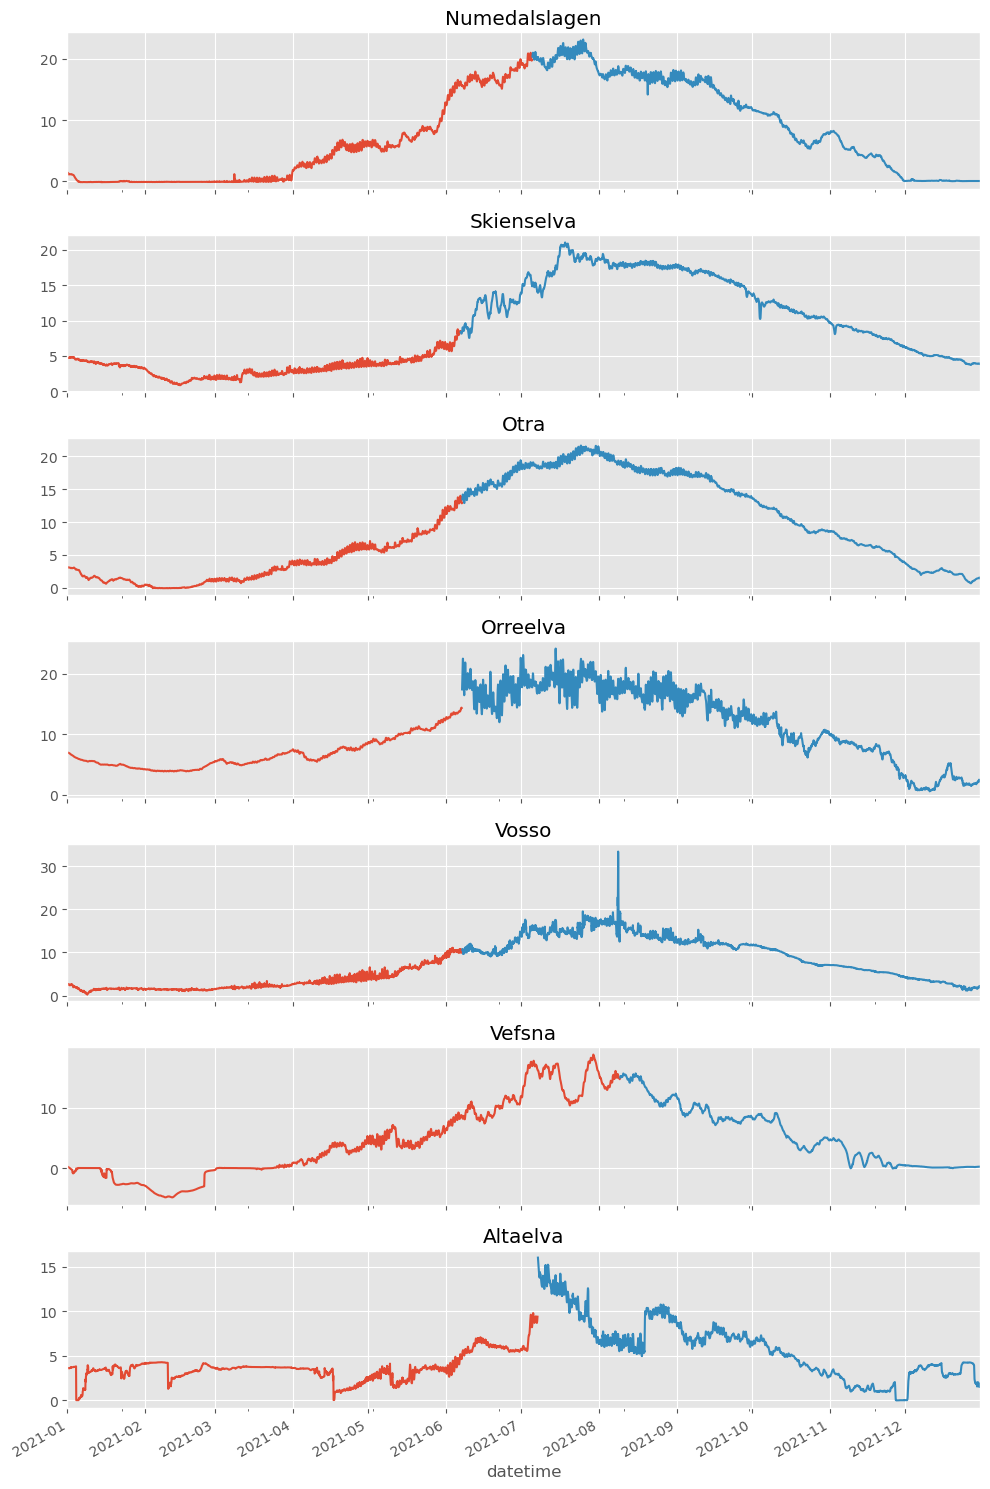

In [14]:
# Container for output
df_list = []

# Setup plot
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 15), sharex=True)

# Loop over stations
for idx, stn_id in enumerate(swap_dates.keys()):
    # Get stn
    stn = swap_dates[stn_id][0]
    print(stn)

    # Get data paths
    path_prev_yr = os.path.join(
        data_fold,
        f"temp_{year - 1}-{year - 2000}/tiny_tag/{stn}_{year - 1}-{year - 2000}.txt",
    )
    path_yr = os.path.join(
        data_fold, f"temp_{year}-{year - 1999}/tiny_tag/{stn}_{year}-{year - 1999}.txt"
    )

    # Parse series 1
    df_prev_yr = pd.read_csv(
        path_prev_yr,
        delim_whitespace=True,
        skiprows=2,
        names=["date", "time", "temp"],
        decimal=prev_dec_sep,
    )
    df_prev_yr["datetime"] = df_prev_yr["date"] + " " + df_prev_yr["time"]
    df_prev_yr["datetime"] = pd.to_datetime(
        df_prev_yr["datetime"], format=prev_dt_fmt
    )
    df_prev_yr.set_index("datetime", inplace=True)
    del df_prev_yr["date"], df_prev_yr["time"]

    # Parse series 2
    df_yr = pd.read_csv(
        path_yr,
        delim_whitespace=True,
        skiprows=2,
        names=["date", "time", "temp"],
        decimal=curr_dec_sep,
    )
    df_yr["datetime"] = df_yr["date"] + " " + df_yr["time"]
    df_yr["datetime"] = pd.to_datetime(df_yr["datetime"], format=curr_dt_fmt)
    df_yr.set_index("datetime", inplace=True)
    del df_yr["date"], df_yr["time"]

    # Get date logger changed
    swap_dt = pd.to_datetime(swap_dates[stn_id][1])
    swap_dt_plus1 = swap_dt + pd.DateOffset(
        hours=3
    )  # Skip 3 hrs to allow time for re-equilibration

    # Truncate series 1
    df_prev_yr = df_prev_yr.truncate(before="%s-01-01 00:00" % year, after=swap_dt)

    # Truncate series 2
    df_yr = df_yr.truncate(before=swap_dt_plus1, after="%s-12-31 23:59" % year)

    # Combine
    df = pd.merge(df_prev_yr, df_yr, how="outer", left_index=True, right_index=True)

    # Plot
    df.plot(ax=axes[idx], legend=False)
    axes[idx].set_title(stn)
    axes[idx].set_xlim([datetime.date(year, 1, 1), datetime.date(year, 12, 31)])

    # Concat to single series
    df = pd.concat([df_prev_yr, df_yr], axis=0, sort=True)

    # Monthly avgs.
    df = df.resample("M").mean()

    # Add to output
    df["station_id"] = stn_id
    df_list.append(df)

plt.tight_layout()

In [15]:
# Combine results
df = pd.concat(df_list, axis=0, sort=True)
df.columns = ["station_id", "Temp_oC"]
df["month"] = df.index.month
df.reset_index(inplace=True)
tt_df = df.pivot(index="station_id", columns="month", values="Temp_oC")

tt_df

month,1,2,3,4,5,6,7,8,9,10,11,12
station_id,,,,,,,,,,,,
29613,3.964247,1.747842,2.285922,3.316639,4.624395,10.719972,17.578172,17.949583,16.161653,11.531369,8.173917,4.825444
29614,1.451156,0.288021,1.899139,4.678806,7.536855,15.104134,19.540753,18.445726,15.897111,10.466094,6.429056,2.216290
29615,0.060806,-0.078943,0.155397,4.322375,7.266868,16.473181,20.295088,17.270376,14.761903,8.612819,4.247306,0.094570
29779,3.132876,3.484360,3.662140,2.415014,2.931142,5.513681,10.435911,7.719220,7.202458,4.800913,1.431625,3.192984
29782,-1.240444,-3.446711,0.053647,2.517319,4.849718,9.365222,14.890860,13.364980,8.826764,5.703208,1.856722,0.180363
29783,5.164099,4.158616,5.770633,6.954361,10.185390,16.101409,18.924892,17.162796,14.514986,10.167141,7.316903,2.013454
29821,1.531949,1.389360,2.020686,3.376875,6.160968,10.677531,15.350968,15.104476,12.062542,9.195946,5.902028,2.858481


## 3. Other logger data

Other temperature data is also available for Målselv and Vegårdselva (= Storelva/Lundevann)

### 3.1. Målselva

In [16]:
# Read raw data
in_xlsx = f"../../../../Data/temperature_data/temp_{year}-{year - 1999}/other/malselva_{year}.xlsx"
df = pd.read_excel(in_xlsx, sheet_name="Temp")
del df["StationName"]
df["Date"] = pd.to_datetime(df["Date"], format="%d.%m.%Y %H:%M:%S")
df.set_index("Date", inplace=True)

# Resample
df = df.resample("M").mean()

# Tidy
df.columns = ["Temp_oC"]
df["month"] = df.index.month
df.reset_index(inplace=True)
del df["Date"]
df["station_id"] = 38005

mal_df = df.pivot(index="station_id", columns="month", values="Temp_oC")

mal_df

month,1,2,3,4,5,6,7,8,9,10,11,12
station_id,,,,,,,,,,,,
38005,0.025481,0.012195,0.011332,0.019157,2.569495,6.535486,11.439222,11.678306,7.167844,3.327356,0.636715,0.080492


### 3.2. Vegårdselva

In [17]:
# Read raw data
in_xlsx = f"../../../../Data/temperature_data/temp_{year}-{year - 1999}/other/vegardselva_{year}.xlsx"
df = pd.read_excel(in_xlsx, sheet_name="Temp")
del df["StationName"]
df["Date"] = pd.to_datetime(df["Date"], format="%d.%m.%Y %H:%M:%S")
df.set_index("Date", inplace=True)

# Resample
df = df.resample("M").mean()

# Tidy
df.columns = ["Temp_oC"]
df["month"] = df.index.month
df.reset_index(inplace=True)
del df["Date"]
df["station_id"] = 30019

veg_df = df.pivot(index="station_id", columns="month", values="Temp_oC")

veg_df

month,1,2,3,4,5,6,7,8,9,10,11,12
station_id,,,,,,,,,,,,
30019,6.972849,5.938271,6.463984,9.349461,12.389328,20.124681,22.706541,19.980242,17.817792,11.906379,7.582045,2.47371


## 4. NVE data

In 2019, NVE datasets were only required for Vikedalselva and Orkla. Due to issues identified above, in 2020 I will also use NVE data for Alta (in previous years we have used more NVE datasets; these are commented out below, but might be relevant again in future).

**Note:** For Orkla, we usually use data from 121.62.0, as this site has a long temperature record. However, in 2020 the data from this location look strange, so for this year (only) I will use data from 121.22.0, which is just downstream

In [18]:
# Dict mapping NVE temp codes to RESA IDs
stn_id_dict = {
    #     "2.1087.0": 29617,
    #     "12.298.0": 29612,
    #     "15.115.0": 29615,
    #     "16.207.0": 29613,
    #     "21.79.0": 29614,
    #     "27.29.0": 29832,
    "38.2.0": 29837,  # Vegardselva
    #     "62.30.0": 29821,
    #     "84.23.0": 29842,
    "121.62.0": 29778,  # Orkla (with long time series, not good in 2020)
    # "121.22.0": 29778,  # Orkla (with OK data for 2020, but nothing before 2014)
    #     "151.32.0": 29782,
    #     "246.11.0": 29819,
    # "212.11.0": 29779,  # Alta
}

# Get stations from HydAPI
nve_stn_df = nivapy.da.get_nve_hydapi_stations(api_key=api_key)
nve_stn_ids = stn_id_dict.keys()
nve_stn_df = nve_stn_df.query("station_id in @nve_stn_ids")
print(f"{len(nve_stn_df)} out of {len(nve_stn_ids)} stations found in HydAPI:")
nve_stn_df

2 out of 2 stations found in HydAPI:


,station_id,station_name,latitude,longitude,utmEast_Z33,utmNorth_Z33,masl,riverName,councilNumber,councilName,...,culQ5,culQ10,culQ20,culQ50,culHm,culH5,culH10,culH20,culH50,seriesList
238,121.62.0,Orkla v/Merk bru,62.90437,9.80669,236297,6985584,204,Orkla,5022,Rennebu,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
1330,38.2.0,Vikedalselva utløp,59.49868,5.91231,-13487,6630782,15,Vikadalselva,1160,Vindafjord,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."


In [19]:
# Get temperature
par_ids = [1003]
st_dt = f"{year}-01-01"
end_dt = f"{year + 1}-01-01"
nve_df = nivapy.da.query_nve_hydapi(
    nve_stn_ids, par_ids, st_dt, end_dt, resolution=1440, api_key=api_key
)
nve_df.head()

,station_id,station_name,parameter,parameter_name,parameter_name_eng,method,datetime,value,unit,correction,quality
0,121.62.0,Orkla v/Merk bru,1003,Vanntemperatur,Water temperature,Mean,2021-01-01 11:00:00+00:00,0.0,°C,0,2
1,121.62.0,Orkla v/Merk bru,1003,Vanntemperatur,Water temperature,Mean,2021-01-02 11:00:00+00:00,0.0,°C,0,2
2,121.62.0,Orkla v/Merk bru,1003,Vanntemperatur,Water temperature,Mean,2021-01-03 11:00:00+00:00,0.0,°C,0,2
3,121.62.0,Orkla v/Merk bru,1003,Vanntemperatur,Water temperature,Mean,2021-01-04 11:00:00+00:00,0.0,°C,0,2
4,121.62.0,Orkla v/Merk bru,1003,Vanntemperatur,Water temperature,Mean,2021-01-05 11:00:00+00:00,0.0,°C,0,2


In [20]:
# Check number of records as expected
days = 366 if calendar.isleap(year) else 365
if len(nve_df) != len(nve_stn_df) * days:
    print("Number of records is not as expected.\n\n")

# Check quality control level
print("The following series have not completed quality control (i.e. 'quality' < 3;")
print("see https://hydapi.nve.no/UserDocumentation/ for details):\n")
print(nve_df.query("quality != 3")[["station_id", "station_name"]].drop_duplicates())

# Check for NaN
if pd.isna(nve_df["value"]).sum() > 0:
    print("\n\nThe following records contain NaN values:\n")
    print(
        nve_df[pd.isna(nve_df["value"])][
            ["station_id", "station_name"]
        ].drop_duplicates()
    )

The following series have not completed quality control (i.e. 'quality' < 3;
see https://hydapi.nve.no/UserDocumentation/ for details):

    station_id        station_name
0     121.62.0    Orkla v/Merk bru
365     38.2.0  Vikedalselva utløp


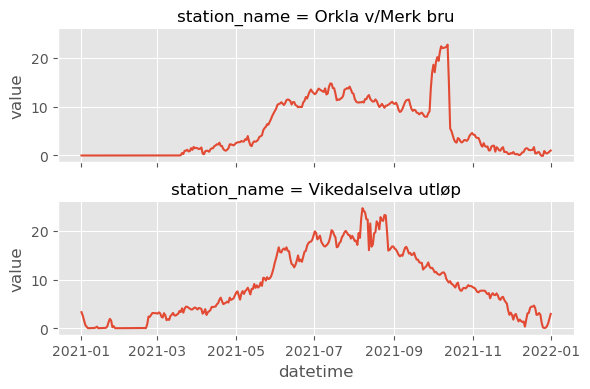

In [21]:
# Plot
sn.relplot(
    x="datetime",
    y="value",
    row="station_name",
    data=nve_df,
    kind="line",
    aspect=3,
    height=2,
    facet_kws={'sharey': True, 'sharex': True},
)

In [22]:
# Resample
df_list = []

for stn_cd in stn_id_dict.keys():
    df = nve_df.query("station_id == @stn_cd").copy()
    df = df.set_index("datetime")[["value"]]
    df = df.resample("M").mean()

    # Convert index to month
    df.index = df.index.month
    df.index.name = "month"

    # Change column to site id
    df.columns = [
        stn_id_dict[stn_cd],
    ]

    # Transpose and append
    df_list.append(df.T)

# Combine
nve_df = pd.concat(df_list, axis=0, sort=True)
nve_df.index.name = "station_id"
nve_df

month,1,2,3,4,5,6,7,8,9,10,11,12
station_id,,,,,,,,,,,,
29837,0.501384,0.772612,3.223932,4.727292,8.841237,15.460694,18.451257,20.003582,14.442055,9.592743,6.579931,2.226143
29778,0.000000,0.000000,0.426210,1.549792,4.291216,11.086007,13.097185,10.918925,9.867625,10.604886,1.825924,0.672910


## Combine

In [23]:
# Melt all and combine
# RESA
man_df2 = man_df.reset_index().melt(id_vars="station_id")
man_df2["source"] = "Manual"

# TinyTag
tt_df2 = tt_df.reset_index().melt(id_vars="station_id")
tt_df2["source"] = "TinyTag"

# Other
mal_df2 = mal_df.reset_index().melt(id_vars="station_id")
mal_df2["source"] = "Other"

veg_df2 = veg_df.reset_index().melt(id_vars="station_id")
veg_df2["source"] = "Other"

# NVE
nve_df2 = nve_df.reset_index().melt(id_vars="station_id")
nve_df2["source"] = "NVE"

# Combine
df = pd.concat([man_df2, tt_df2, mal_df2, veg_df2, nve_df2], axis=0, sort=True)

# Join stn codes
df = pd.merge(df, stn_df[["station_id", "station_code"]], how="left", on="station_id")
del df["station_id"]
df.columns = ["Month", "Source", "Temperature (C)", "Station code"]

df.head()

,Month,Source,Temperature (C),Station code
0,1,Manual,1.3,BUSEDRA
1,1,Manual,0.7,ØSTEGLO
2,1,Manual,3.1,FINEPAS
3,1,Manual,0.0,FINETAN
4,1,Manual,NaN,MROEDRI


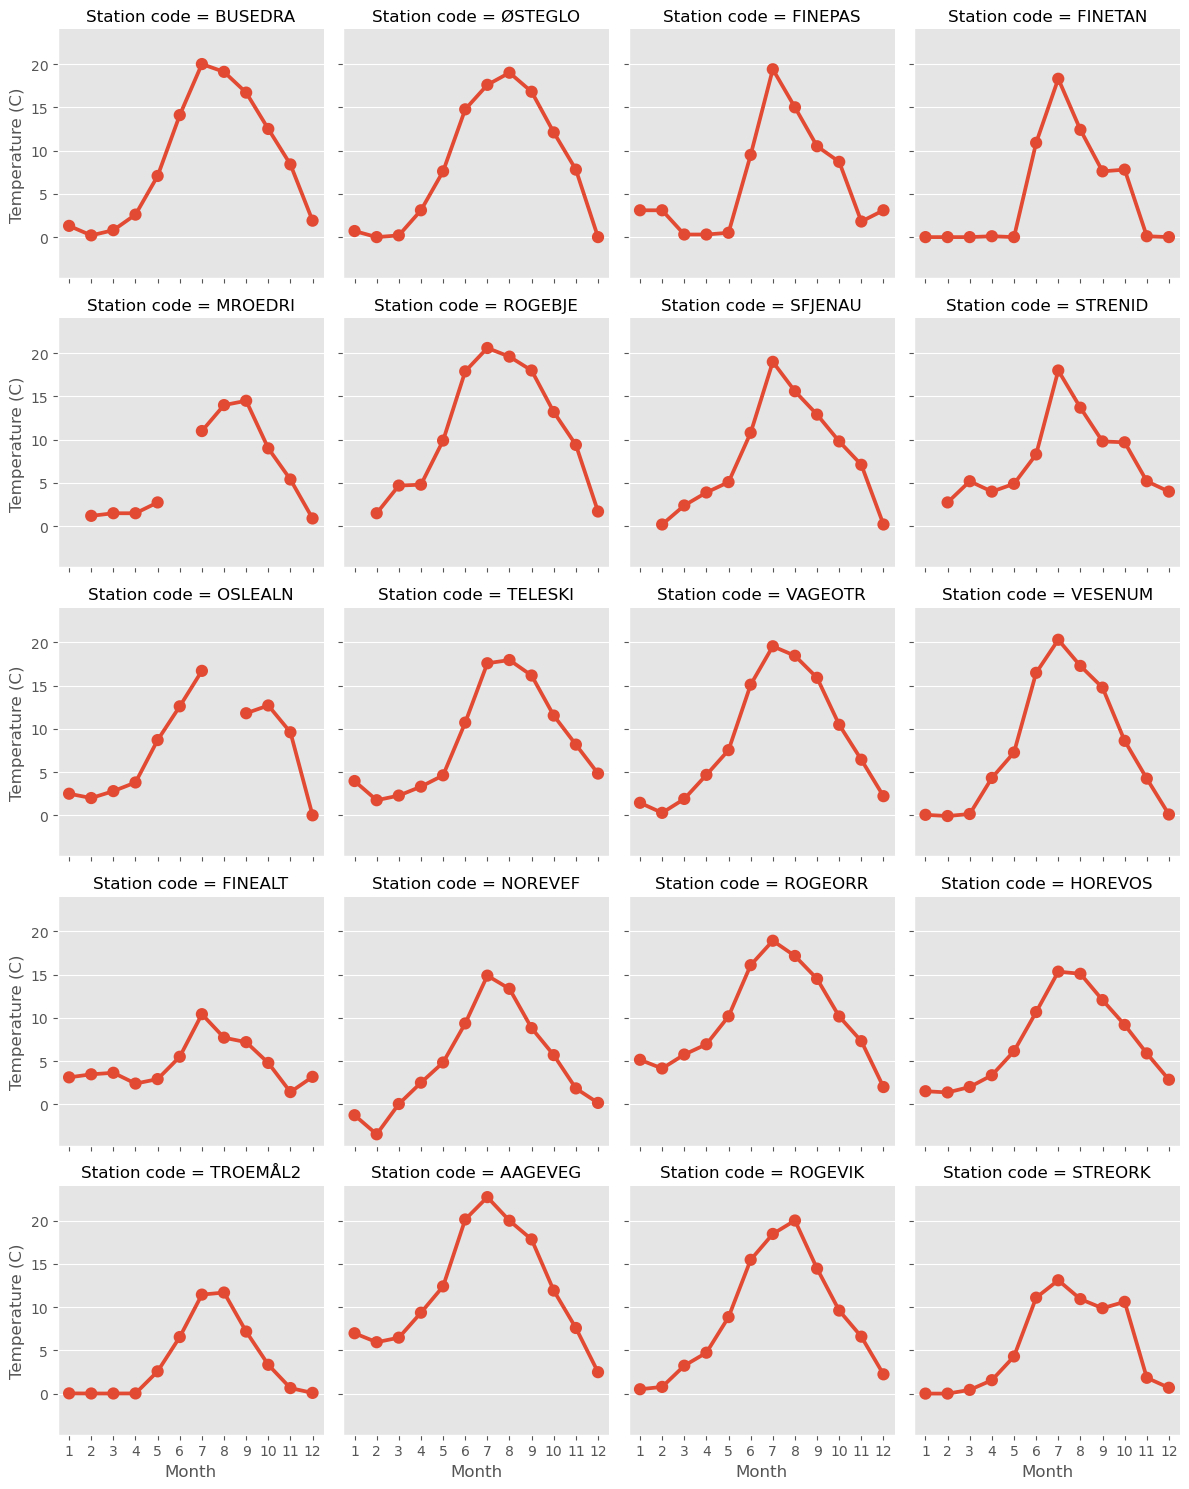

In [25]:
# Plot
sn.catplot(
    x="Month",
    y="Temperature (C)",
    data=df,
    # hue='Source',
    col="Station code",
    col_wrap=4,
    height=3,
    # linestyles=['--', '--', '--', '--'],
    kind="point",
)

# Save
out_path = f"../../../../Data/temperature_data/temp_{year}-{year - 1999}/temps_all_sources_{year}.png"
plt.savefig(out_path, dpi=300)

## 5. Format for output

In [26]:
# Combine
df = pd.concat([man_df, tt_df, mal_df, veg_df, nve_df], axis=0, sort=True)
df.reset_index(inplace=True)

# Join station details
df = pd.merge(df, stn_df, how="left", on="station_id")

# Reorder
df = df[
    ["station_id", "station_code", "station_name", "latitude", "longitude", "altitude"]
    + list(range(1, 13))
]
del df["latitude"], df["longitude"], df["altitude"]

# Round values
df = df.round(2)

# Save output
out_csv = f"../../../../Data/temperature_data/temp_{year}-{year - 1999}/monthly_avg_temps_{year}-{year - 1999}.csv"
df.to_csv(out_csv, encoding="utf-8", index=False)

df

,station_id,station_code,station_name,1,2,3,4,5,6,7,8,9,10,11,12
0,29612,BUSEDRA,Drammenselva,1.30,0.20,0.80,2.60,7.07,14.10,20.00,19.10,16.70,12.50,8.40,1.90
1,29617,ØSTEGLO,Glomma ved Sarpsfoss,0.70,0.00,0.20,3.10,7.60,14.77,17.60,19.00,16.80,12.10,7.80,0.00
2,29819,FINEPAS,Pasvikelva,3.10,3.10,0.30,0.30,0.50,9.50,19.40,15.00,10.50,8.70,1.80,3.10
3,29820,FINETAN,Tanaelva,0.00,0.00,0.00,0.10,0.00,10.90,18.30,12.40,7.60,7.80,0.10,0.00
4,29822,MROEDRI,Driva,NaN,1.20,1.50,1.50,2.75,NaN,11.00,14.00,14.50,9.00,5.40,0.90
5,29832,ROGEBJE,Bjerkreimselva,NaN,1.50,4.70,4.80,9.90,17.90,20.60,19.60,18.00,13.20,9.40,1.70
6,29842,SFJENAU,Nausta,NaN,0.20,2.40,3.90,5.10,10.80,19.00,15.60,12.90,9.80,7.10,0.20
7,29844,STRENID,Nidelva (Tr.heim),NaN,2.75,5.20,4.00,4.90,8.30,18.00,13.70,9.80,9.70,5.20,4.00
8,36225,OSLEALN,Alna,2.50,2.00,2.80,3.80,8.70,12.60,16.70,NaN,11.80,12.70,9.60,0.00
9,29613,TELESKI,Skienselva,3.96,1.75,2.29,3.32,4.62,10.72,17.58,17.95,16.16,11.53,8.17,4.83
